In [1]:
import sys
sys.path.insert(0, './../hyperAFM')
import matplotlib.pyplot as plt
import numpy as np
import util
import jeff_hypir 
import FindPeak
import AllRelativePeakIntensities
import peakutils
%matplotlib inline


from sklearn.decomposition import PCA as sklearnPCA
from sklearn import preprocessing
import math

In [2]:
#load hyperspectral image
hyperspectral = util.HyperImage('./../../../../../Desktop/Set2/Film12topo_0058.txt')
hypertopo = hyperspectral.channel_data[:,:,0]
hyperimage = hyperspectral.hyper_image
#load cAFM image
cAFM4 = util.load_ibw('./../Data/SKPMcAFM_set2/MAPIFilm12cAFM_0004.ibw')
topo4 = cAFM4[:,:,0]
#take average of all spectra in hyperspectral image. 
#use it to find peaks and display the average spectrum. 
peaklocs, spectrum = jeff_hypir.get_hyper_peaks(hyperimage, threshold=0.01)

ValueError: could not broadcast input array from shape (559) into shape (5)

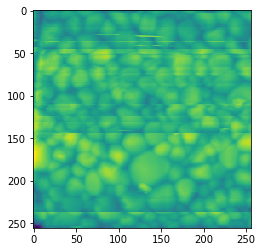

In [3]:
#cAFM topo
plt.imshow(topo4)

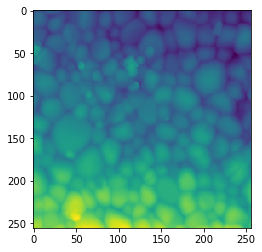

In [4]:
#hyper topo
hypertopo = hyperspectral.channel_data[:,:,0]
hypertopo=hypertopo[:,::-1]
plt.imshow(hypertopo)

In [6]:
aligned = util.align_images(hyperspectral.channel_data, cAFM4)
alignedtopo = aligned[:,:,0]

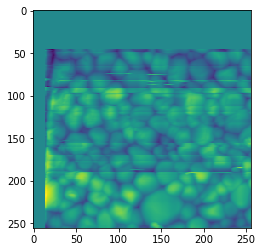

In [7]:
plt.imshow(alignedtopo)

In [8]:
otherspectrum=hyperimage[0][0]

In [9]:
def FindPeaks(spectrum, thres=0.01, min_dist=1):
    """This function takes a spectrum and identifies the absorption peaks.
    the peaks it identifies has intensity with the  minimum threshold 
    specified with spacing between peaks at least min_dist.
    
    PARAMETERS: 
        spectrum: list of intensities; you need to know the wavenumber
        range of the spectrum! 
        
        thres: minimum relative intensity required to be considered a peak.
        Only peaks with relative amplitude higher than threshold will 
        be counted.
        
        min_dist: minimum index spacing between two peaks. Setting this to
        1 means that the minimum distance between two peaks is the resolution
        of the IR spectrum, which is specified during the experiment. 
        
        Also see peakutils.peak.indexes at: 
        http://pythonhosted.org/PeakUtils/reference.html
    
    RETURNS:
        A dictionary with the peak positions and intensities. 
    
    """
    #use peak utils to find indices of peaks.
    peakindices = peakutils.indexes(spectrum, thres=thres,
                                    min_dist=min_dist)
    
    #create empty dictionary to store peak position and intensity
    peaksdict={}
    #loop through all indices identified by peakutils and store its position
    #and intensity
    for index in peakindices:
        #store each value as a 1-element list
        peaksdict[index] = []
        peaksdict[index].append(spectrum[index])
    return peakindices, peaksdict
def FindSamePeaks(indices, peaksdict, otherspectrum):
    """This function takes the indices of peak positions and finds the 
    intensity of those same peaks in a different spectrum. 
    
    INPUTS: indices: list of indices from FindPeaks
            peaksdict: dictionary of peak positions and intensities from 
                        FindPeaks
            otherspectrum: function will look in this spectrum for the same
                        peaks 

    RETURNS: peaksdict with the intensity of the peak in other 
             spectrum appended. 
    """
    #not sure if it is better to figure out how to 
    #append as an array and then reshape for plotting or
    #if its better to store everything in a list and then
    #reshape for plotting. 
    for index in indices:
        otherpeakintensity=otherspectrum[index]
        peaksdict[index].append(otherpeakintensity)
    return peaksdict

def hyperpeakintensities (peakindices, peaksdict, hyperimage): 
    """Takes a hyperimage and extracts the intensity at each index
    from every pixel in the image and appends it to a dictionary.
    
    INPUT: peakindices are indices where there are peaks; these are not in wavenumbers. 
            peaksdict: dictionary of intensities at different peak positions, with the intensities
            from the average spectrum. 
            hyperimage: 3 dimensional np array. First two indices refer to pixel in 
            x-, y- space and the third contains the IR spectrum at each pixel. 
    RETURNS: dictionary with intensity at each peak for each spectrum appended. The first value 
            for each key is the intensity corresponding to the average peak intensity. 
    """
    
    #define dimensions of image
    dimensions = hyperimage.shape
    xaxis = dimensions[0]
    yaxis = dimensions[1]
    
    for x in range(xaxis):
        for y in range(yaxis):
            peaksdict = FindSamePeaks(peakindices, peaksdict,hyperimage[x][y])
    return peaksdict 

In [10]:
#locate peaks based on average spectrum, create dictionary of peak positions and intensities 
peakindices, peaksdict = FindPeaks(spectrum, thres=0.01, min_dist=1)

In [79]:
#find the peaks in the average spectrum in each spectrum at every pixel and append to dictionary 
fulldictionary=hyperpeakintensities(peakindices, peaksdict, hyperimage)

In [13]:
def dictionarytomatrix(dictionary, lenvalue):
    """Takes dictionary and converts it into a matrix where each 
    row corresponds to a pixel and each column corresponds to the
    intensity of the peak at that pixel."""
    #initialize matrix
    spectralmatrix = np.zeros((lenvalue, len(dictionary.keys())))
    counter = 0
    for key in dictionary:
        #reshape each list into a column
        columni = np.reshape(dictionary[key], (1, lenvalue))
        #append to spectral matrix at appropriate column
        spectralmatrix[:,counter] = columni
        counter += 1
    return spectralmatrix

In [6]:
SpectMatrix=dictionarytomatrix(fulldictionary, 65537)
average=SpectMatrix[:,0]
pointintensity=SpectMatrix[:,1:]

NameError: name 'dictionarytomatrix' is not defined

In [55]:
column1=pointintensity[:,1]
column1.shape
np.average(column1)

0.00029568182821655274

In [56]:
#standardize data onto unitscale (mean=0, variance=1)
#in_std=StandardScaler().fit_transform(column1)
in_std=preprocessing.scale(pointintensity)

In [65]:
#check that the data has been standardized (average 0, std dev = 1)
average=np.average(in_std)
std=np.std(in_std)

In [66]:
print(average,std)

(-3.4435342499017783e-15, 1.0000000000000007)


In [71]:
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(in_std.T)

In [72]:
Y_sklearn.shape

(14, 2)

In [69]:
column0 = Y_sklearn[:,1]

In [76]:
tot = 0 
for i in range(14):
    tot += column0[i]**2
    

see: https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/decomposition/pca.py#L310

also:https://stats.stackexchange.com/questions/235882/pca-in-numpy-and-sklearn-produces-different-results 

In [78]:
column0[0]**2 

7411.5409482149935